In [2]:
%load_ext autoreload
%autoreload 2

import analyze_utils

In [3]:
all_dfs = {}
all_losses = {}
for ds in ['ffb', 'imdb', 'rt', 'sst2', 'tweets']:
    print(ds)
    save_dir = f'/home/johnmorris/interpretable-autoprompting/results/autoprompt_sentiment/{ds}'
    df, losses = analyze_utils.load_results_and_cache_autoprompt_json(save_dir, save_file='r.pkl', include_losses=True)
    all_dfs[ds] = df
    all_losses[ds] = losses

ffb


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 12.33it/s]


imdb


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.66it/s]


rt


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.89it/s]


sst2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.06it/s]


tweets


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 19.62it/s]


In [141]:
all_dfs['ffb'][all_dfs['ffb']['model_cls'] == 'autoprompt'][['prefixes', 'prefix_n_queries']]

,prefixes,prefix_n_queries
0,maybe Yesthe confined introducefineKeanswerwi...,2
1,maybe Yesthe confined introduce crucialKeansw...,2
2,maybe Yesthe confined introducepositiveKeansw...,2
3,maybe Yesthe confined introduceproducedKeansw...,2
4,maybe Yesthe confined introduce PrKeanswerwit...,2
...,...,...
123,selfiethe rumor Asus clearediscPad?: GotIs pa...,2
124,selfiethe rumor Asus clearediscPad?: GotIs pa...,2
125,selfiethe rumor Asus clearediscPad?: GotIs pa...,2
126,?:thethethethethethethethethethethethethethethe,2


In [144]:
full_df = pd.concat(all_dfs.values())

(
full_df.groupby(['task_name', 'model_cls', 'seed']).first()[['prefixes', 'prefix_train_loss', 'prefix_train_acc',  'prefix_n_queries']]
    .to_pickle('../results/autoprompt_sentiment/prompts.pkl')
)

In [22]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [76]:
from typing import List

sns.set_theme(style="white")

def _smooth(losses: List[float], n_window=1) -> List:
    if isinstance(losses, list): losses = pd.Series(losses)
    l_smooth = []
    for i in range(n_window, len(losses)-n_window):
        window = losses[i-n_window:i+n_window+1]
        l_smooth.append( sum(window) / len(window))

    return l_smooth


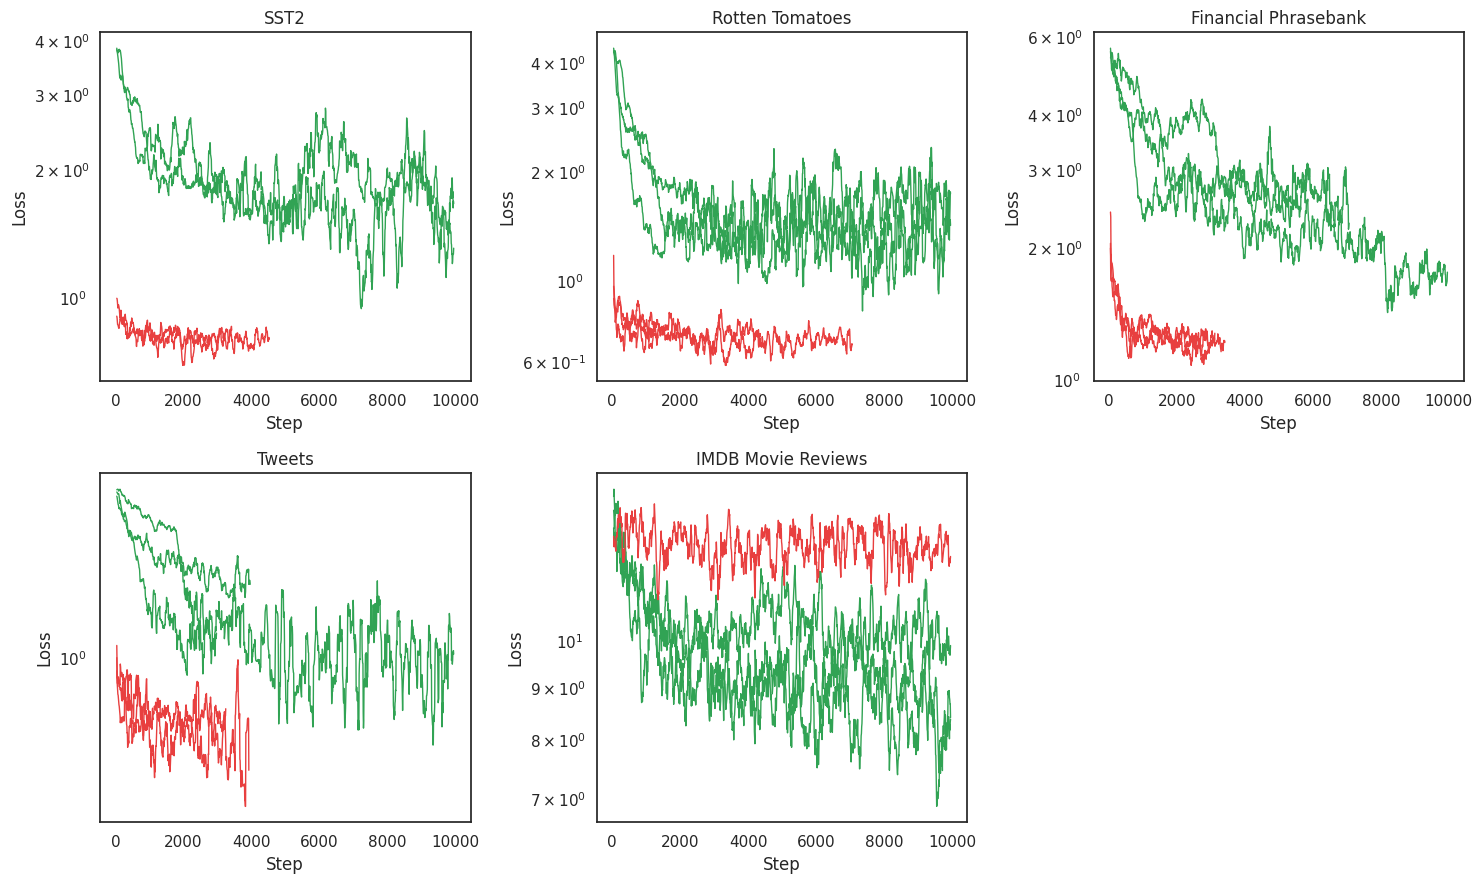

In [121]:
NICE_DATASET_NAMES = {
    'sst2': 'SST2',
    'rt': 'Rotten Tomatoes',
    'ffb': 'Financial Phrasebank',
    'tweets': 'Tweets',
    'imdb': 'IMDB Movie Reviews',
}

fig, ax_list = plt.subplots(nrows=2, figsize=(15, 9), ncols=3)# , sharex=True)
for i, dataset_name in enumerate(NICE_DATASET_NAMES.keys()):
    ax = ax_list[i//3][i%3]
    mini_df = all_dfs[dataset_name].groupby(['model_cls', 'seed']).first().reset_index()
    mini_df['legend'] = mini_df.apply(analyze_utils.get_legend__autoprompt, axis=1)
    mini_df['loss'] = all_losses[dataset_name]
    mini_df['step'] = mini_df.apply(lambda row: np.arange(len(row['loss'])) * row['batch_size'], axis=1)

    for i in range(len(mini_df)):
        _n=5
        y = _smooth(mini_df['loss'][i], _n)
        x = mini_df['step'][i][_n:-_n]
        color = analyze_utils.COLORS[mini_df.iloc[i]['legend']]
        sns.lineplot(x=x, y=y, linewidth=1, color=color, ax=ax)

    ax.set_xlabel('Step')
    ax.set_ylabel('Loss')
    ax.set_yscale('log') 
    ax.set_title(f'{NICE_DATASET_NAMES[dataset_name]}')

fig.delaxes(ax_list[-1][-1]) # hide the last one
plt.tight_layout()